# Sex-specific cardiac disease classifiers

#### Packages

In [112]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
import xgboost as xgb
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from matplotlib import pyplot as plt

## DATA

#### Data import and pre-processing

In [113]:
csv_file = 'HeartDiseaseLarge.csv'
dataframe = pd.read_csv(csv_file)
dataframe = dataframe.sample(frac = 1).reset_index(drop = True) # Shuffle the data frame for randomness

def preprocess_df(dataframe, sex = 'both') :
    # dataframe = pd.read_csv(csv_file)
    if sex == 'female' :
        dataframe = dataframe.loc[dataframe['Sex'] == 0]
    elif sex == 'male' :
        dataframe = dataframe.loc[dataframe['Sex'] == 1]
        
    dataframe = dataframe.drop(columns = ['eid']) # Drop the eid column
    
    if not sex == 'both' :
        dataframe = dataframe.drop(columns = ['Sex'])
        
    m_patients = len(dataframe.index) # Number of patients
    
    return dataframe, m_patients
    
def buildXY(dataframe) :
    df = dataframe.copy()
    target_all = df.pop('HeartDisease') # OUTPUT
    target_hyper = df.pop('HypertensiveDiseases')
    target_isch = df.pop('IschaemicHeartDiseases')
    target_cond = df.pop('ConductionDisorders')
    targets = [target_all, target_hyper, target_isch, target_cond]
    
    features_tensor = tf.convert_to_tensor(df) # INPUT features (tensor)
    
    return df, features_tensor, targets

df_both, m_both = preprocess_df(dataframe)
df_female, m_female = preprocess_df(dataframe, sex = 'female')
df_male, m_male = preprocess_df(dataframe, sex = 'male')

features_both_df, features_both, targets_both = buildXY(df_both)
features_female_df, features_female, targets_female = buildXY(df_female)
features_male_df, features_male, targets_male = buildXY(df_male)
features_df = [features_both_df, features_female_df, features_male_df]
features = [features_both, features_female, features_male]
targets = [targets_both, targets_female, targets_male]



Plot some relations of the features to the disease

AttributeError: 'PairGrid' object has no attribute 'get_figure'

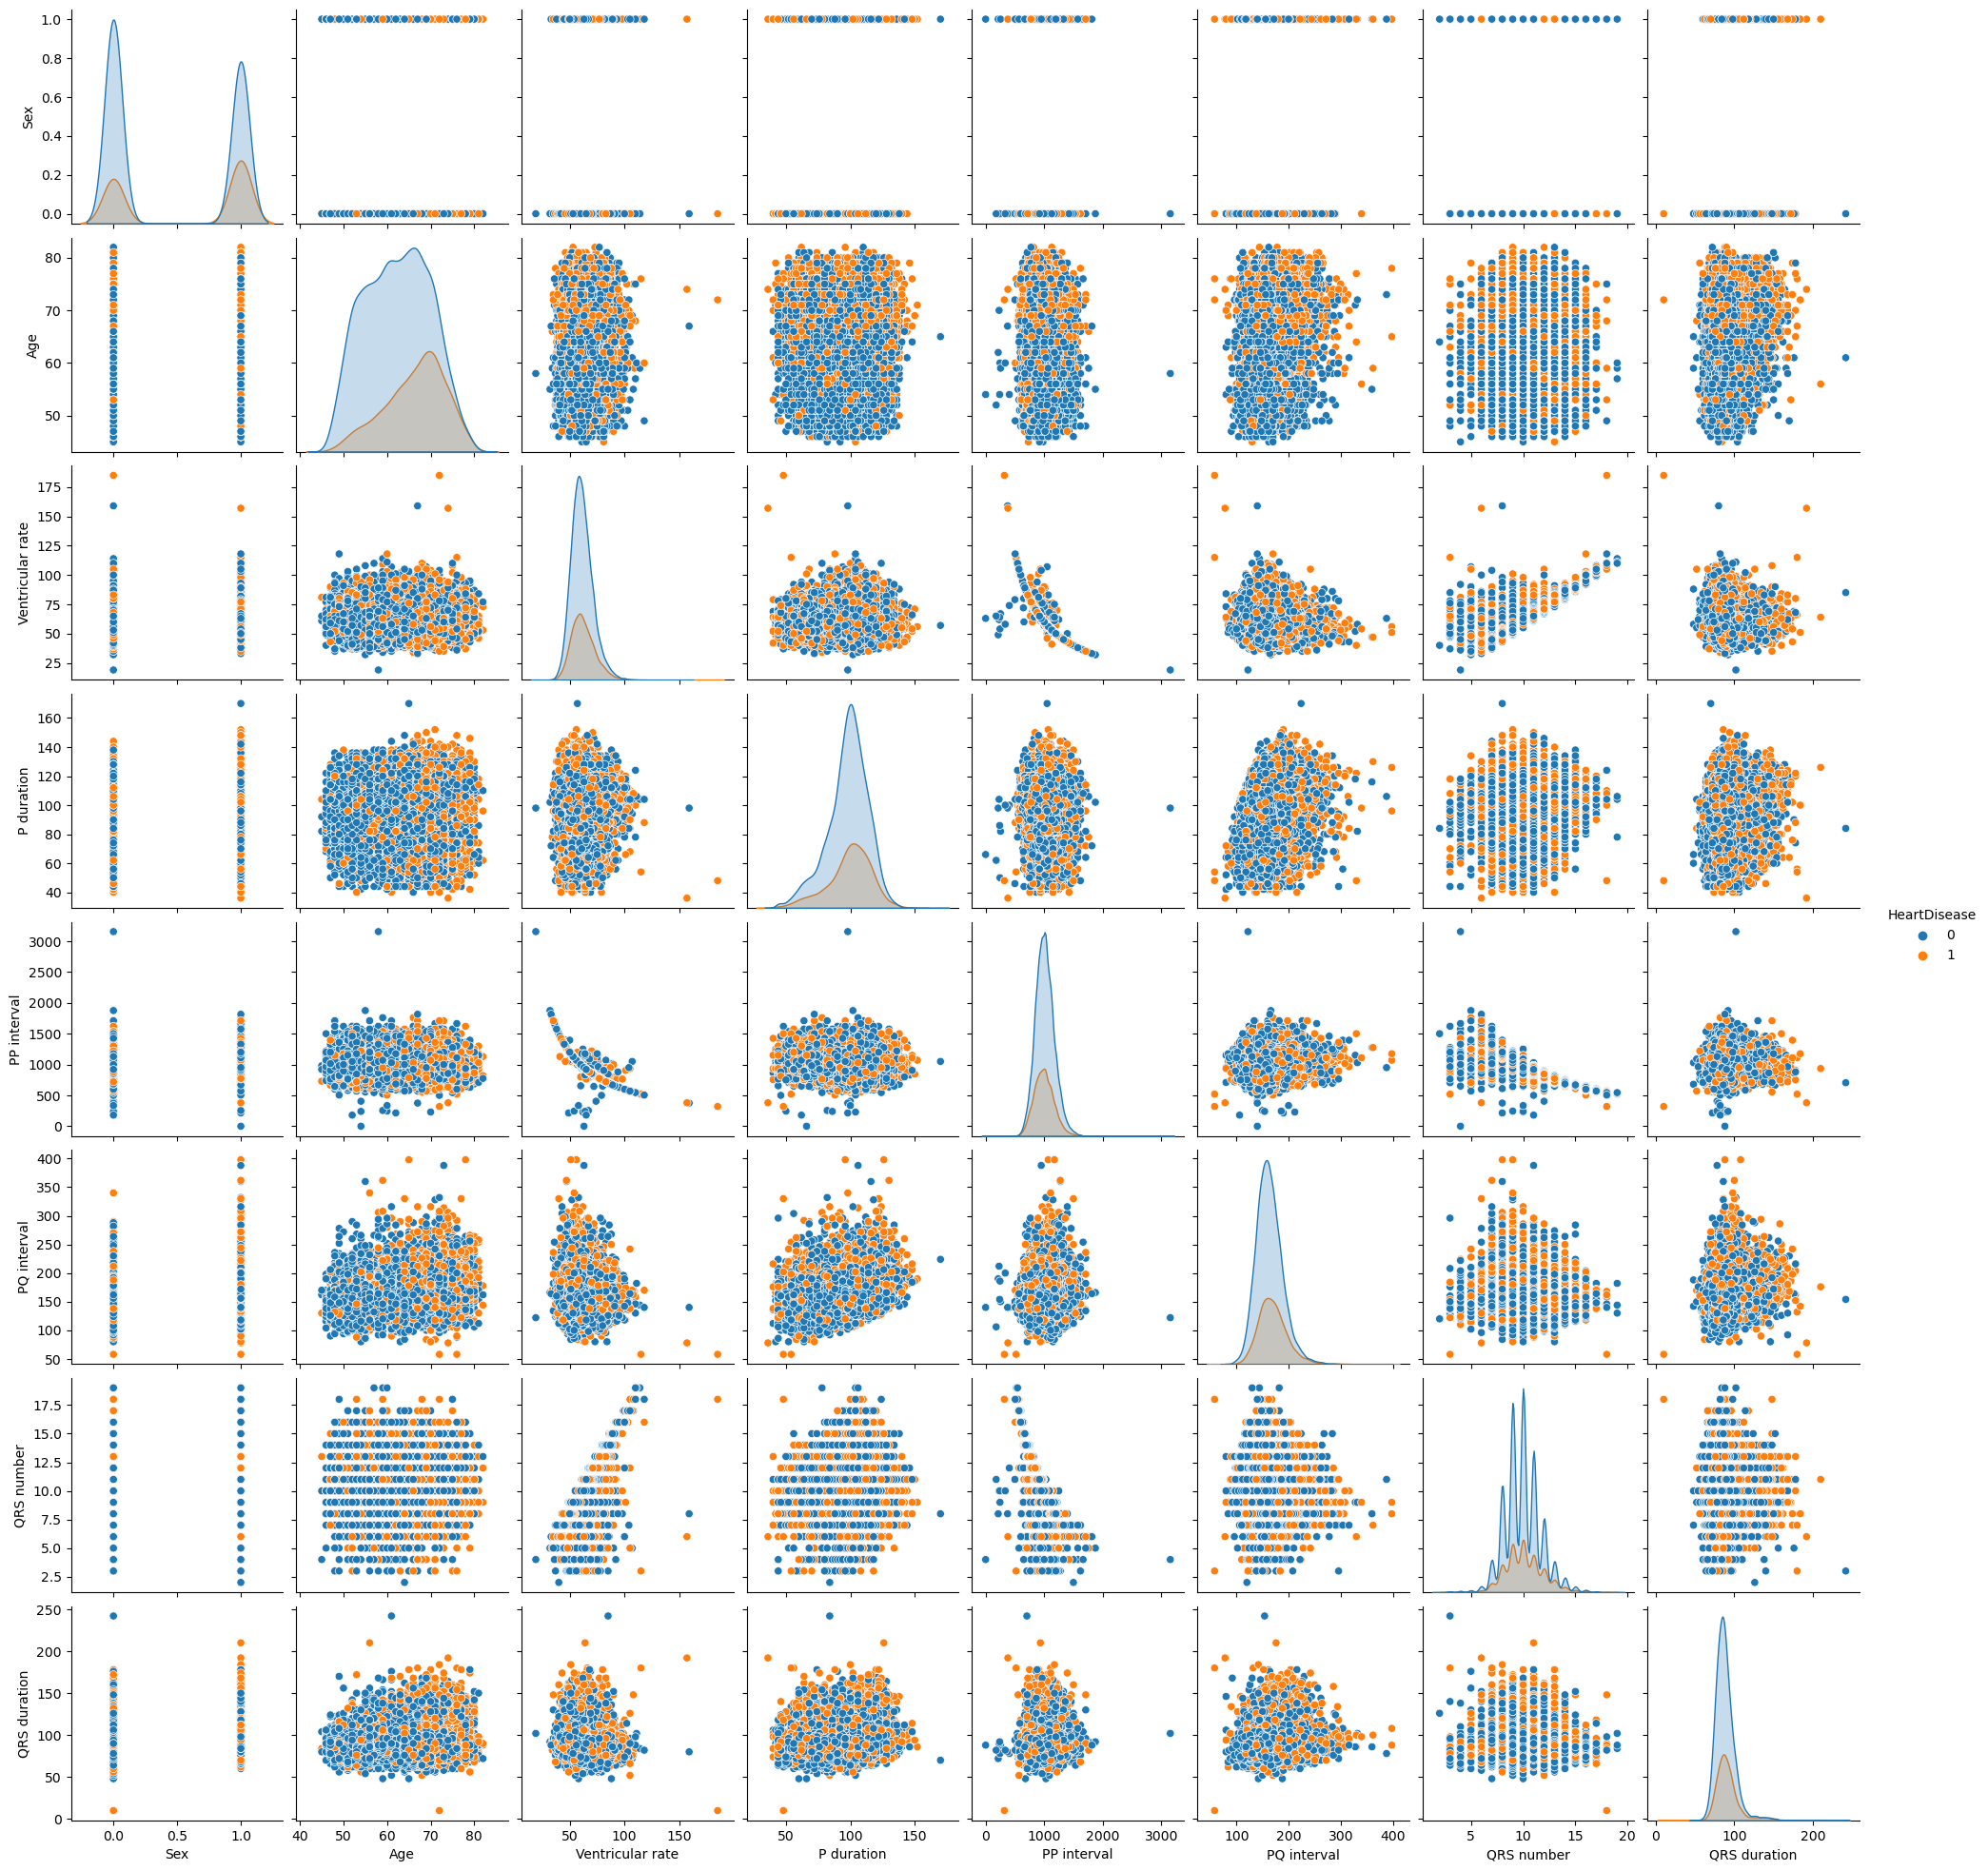

In [106]:
feature_plot = sns.pairplot(df_both.iloc[:, np.r_[-4, 0:8]], hue = 'HeartDisease', diag_kind='kde');
fig = feature_plot.get_figure()
fig.savefig("PairwisePlot.png") 

In [108]:
fig = feature_plot.fig
fig.savefig("PairwisePlot.png", dpi = 600) 

Standarization

In [114]:
def normalization_layer(features) :
    # Define the feature normalizer layer
    normalizer = tf.keras.layers.Normalization(axis = -1)
    normalizer.adapt(features)
    
    return normalizer

# normalizers = [normalization_layer(features_both), normalization_layer(features_female), normalization_layer(features_male)]

# normalizers[0](features_both) # Normalization sanity check

## MODELS

### Sequantial DNNs

In [115]:
def build_baseline_DNN(features, target, train_frac = 0.8, valtest_frac = 0.2, batch_size = 32, max_epochs = 100, oversample = False) :
    # Constants for training/val/testing and batching
    m = len(target) # number of patients
    m_validate = int(valtest_frac / 2 * m) # test size is same as validation size
    m_train = int(train_frac * m)
    buffer_size = m
    steps_per_epoch = m_train // batch_size
    
    train_features = features[0:m_train, :]
    train_target = target[0:m_train]

    # Build dataset object from the tensor
    ds = tf.data.Dataset.from_tensor_slices((features, target))
    # ds_shuffled = ds.shuffle(buffer_size, reshuffle_each_iteration = False)
    
    # Split into training, validation, and testing sets
    train_ds = []
    if oversample :
        bool_train_labels = target[0:m_train] != 0
    
        #pos_features = train_features[bool_train_labels, :]
        pos_features = tf.boolean_mask(train_features, bool_train_labels)
        neg_features = tf.boolean_mask(train_features, ~bool_train_labels)
        #neg_features = train_features[~bool_train_labels, :]
        
        pos_labels = train_target[bool_train_labels]
        neg_labels = train_target[~bool_train_labels]
        
        pos_ds = tf.data.Dataset.from_tensor_slices((pos_features, pos_labels)).shuffle(buffer_size).repeat()
        neg_ds = tf.data.Dataset.from_tensor_slices((neg_features, neg_labels)).shuffle(buffer_size).repeat()
        train_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5]).batch(batch_size).prefetch(2)
    else :
        train_ds = ds.take(m_train).cache()
        train_ds = train_ds.shuffle(buffer_size, reshuffle_each_iteration = True).repeat().batch(batch_size).prefetch(2)
    
        
    validate_ds = ds.skip(m_train).take(m_validate).cache()
    test_ds = ds.skip(m_train).skip(m_validate).cache()

    # Shuffle and batch the training and validation sets (no shuffling for validation set)
    validate_ds = validate_ds.batch(batch_size).prefetch(2)
    
    # Standarization layer
    # normalizer = normalization_layer(train_ds)
    normalizer = tf.keras.layers.Normalization(axis = -1)
    normalizer.adapt(train_features)
    
    # Sequential DNN for binary classification
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    
    return (model, train_ds, validate_ds, test_ds, steps_per_epoch, max_epochs)

#### Build 12 DNN models

In [124]:
MAX_EPOCHS = 50
models_dnn = [build_baseline_DNN(features[i], Y, max_epochs = MAX_EPOCHS, oversample = True) for i in range(len(features)) for Y in targets[i]]

#### Train the 12 DNN models

In [126]:
# SERIAL
history = [dnn[0].fit(dnn[1], steps_per_epoch = dnn[4], epochs = dnn[5], validation_data = dnn[2], verbose = 1) for dnn in models_dnn]

Epoch 1/50
606/606 [==============================] - 3s 2ms/step - loss: 2.0136 - accuracy: 0.5719 - precision: 0.5646 - recall: 0.5990 - val_loss: 1.4824 - val_accuracy: 0.6393 - val_precision: 0.3688 - val_recall: 0.5525
Epoch 2/50
606/606 [==============================] - 1s 1ms/step - loss: 1.2158 - accuracy: 0.6257 - precision: 0.6114 - recall: 0.6890 - val_loss: 0.9876 - val_accuracy: 0.6344 - val_precision: 0.3706 - val_recall: 0.5908
Epoch 3/50
606/606 [==============================] - 1s 1ms/step - loss: 0.8753 - accuracy: 0.6385 - precision: 0.6225 - recall: 0.6773 - val_loss: 0.7523 - val_accuracy: 0.6801 - val_precision: 0.4151 - val_recall: 0.5764
Epoch 4/50
606/606 [==============================] - 1s 1ms/step - loss: 0.7293 - accuracy: 0.6490 - precision: 0.6349 - recall: 0.6975 - val_loss: 0.7116 - val_accuracy: 0.6002 - val_precision: 0.3676 - val_recall: 0.7564
Epoch 5/50
606/606 [==============================] - 1s 1ms/step - loss: 0.6705 - accuracy: 0.6482 - pr

606/606 [==============================] - 1s 1ms/step - loss: 0.6324 - accuracy: 0.6516 - precision: 0.6385 - recall: 0.6898 - val_loss: 0.6318 - val_accuracy: 0.6542 - val_precision: 0.3938 - val_recall: 0.6226
Epoch 38/50
606/606 [==============================] - 1s 1ms/step - loss: 0.6308 - accuracy: 0.6520 - precision: 0.6436 - recall: 0.6884 - val_loss: 0.6457 - val_accuracy: 0.6171 - val_precision: 0.3757 - val_recall: 0.7245
Epoch 39/50
606/606 [==============================] - 1s 1ms/step - loss: 0.6295 - accuracy: 0.6504 - precision: 0.6322 - recall: 0.7161 - val_loss: 0.6544 - val_accuracy: 0.6109 - val_precision: 0.3709 - val_recall: 0.7229
Epoch 40/50
606/606 [==============================] - 1s 2ms/step - loss: 0.6308 - accuracy: 0.6509 - precision: 0.6403 - recall: 0.6932 - val_loss: 0.6516 - val_accuracy: 0.6373 - val_precision: 0.3846 - val_recall: 0.6688
Epoch 41/50
606/606 [==============================] - 1s 2ms/step - loss: 0.6307 - accuracy: 0.6512 - precision

606/606 [==============================] - 1s 2ms/step - loss: 0.6070 - accuracy: 0.6801 - precision: 0.6554 - recall: 0.7562 - val_loss: 0.7157 - val_accuracy: 0.4514 - val_precision: 0.2529 - val_recall: 0.9281
Epoch 24/50
606/606 [==============================] - 1s 2ms/step - loss: 0.6115 - accuracy: 0.6738 - precision: 0.6467 - recall: 0.7630 - val_loss: 0.6748 - val_accuracy: 0.5874 - val_precision: 0.2944 - val_recall: 0.7992
Epoch 25/50
606/606 [==============================] - 1s 1ms/step - loss: 0.6117 - accuracy: 0.6692 - precision: 0.6444 - recall: 0.7507 - val_loss: 0.6024 - val_accuracy: 0.6204 - val_precision: 0.3098 - val_recall: 0.7717
Epoch 26/50
606/606 [==============================] - 1s 1ms/step - loss: 0.6064 - accuracy: 0.6792 - precision: 0.6534 - recall: 0.7669 - val_loss: 0.6237 - val_accuracy: 0.6270 - val_precision: 0.3157 - val_recall: 0.7822
Epoch 27/50
606/606 [==============================] - 1s 1ms/step - loss: 0.6072 - accuracy: 0.6725 - precision

606/606 [==============================] - 1s 1ms/step - loss: 0.6098 - accuracy: 0.7122 - precision: 0.6929 - recall: 0.7736 - val_loss: 0.6402 - val_accuracy: 0.6707 - val_precision: 0.1220 - val_recall: 0.6108
Epoch 10/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5959 - accuracy: 0.7241 - precision: 0.6944 - recall: 0.8022 - val_loss: 0.5340 - val_accuracy: 0.7110 - val_precision: 0.1332 - val_recall: 0.5808
Epoch 11/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5933 - accuracy: 0.7234 - precision: 0.6912 - recall: 0.8010 - val_loss: 0.6070 - val_accuracy: 0.7354 - val_precision: 0.1295 - val_recall: 0.4970
Epoch 12/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5857 - accuracy: 0.7288 - precision: 0.6985 - recall: 0.8047 - val_loss: 0.6144 - val_accuracy: 0.6616 - val_precision: 0.1250 - val_recall: 0.6527
Epoch 13/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5839 - accuracy: 0.7320 - precision

606/606 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.7828 - precision: 0.7448 - recall: 0.8698 - val_loss: 0.5627 - val_accuracy: 0.7218 - val_precision: 0.1351 - val_recall: 0.5629
Epoch 46/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7821 - precision: 0.7456 - recall: 0.8535 - val_loss: 0.6021 - val_accuracy: 0.6913 - val_precision: 0.1191 - val_recall: 0.5449
Epoch 47/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5324 - accuracy: 0.7783 - precision: 0.7398 - recall: 0.8522 - val_loss: 0.5939 - val_accuracy: 0.6888 - val_precision: 0.1250 - val_recall: 0.5868
Epoch 48/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5285 - accuracy: 0.7844 - precision: 0.7494 - recall: 0.8613 - val_loss: 0.5635 - val_accuracy: 0.7234 - val_precision: 0.1305 - val_recall: 0.5329
Epoch 49/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5302 - accuracy: 0.7835 - precision

606/606 [==============================] - 1s 1ms/step - loss: 0.5128 - accuracy: 0.8036 - precision: 0.7695 - recall: 0.8653 - val_loss: 0.6136 - val_accuracy: 0.7090 - val_precision: 0.0785 - val_recall: 0.5333
Epoch 32/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5123 - accuracy: 0.8048 - precision: 0.7676 - recall: 0.8762 - val_loss: 0.6075 - val_accuracy: 0.6958 - val_precision: 0.0786 - val_recall: 0.5619
Epoch 33/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5131 - accuracy: 0.8040 - precision: 0.7674 - recall: 0.8783 - val_loss: 0.6298 - val_accuracy: 0.6979 - val_precision: 0.0780 - val_recall: 0.5524
Epoch 34/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5117 - accuracy: 0.8046 - precision: 0.7686 - recall: 0.8689 - val_loss: 0.5653 - val_accuracy: 0.7716 - val_precision: 0.0850 - val_recall: 0.4381
Epoch 35/50
606/606 [==============================] - 1s 1ms/step - loss: 0.5149 - accuracy: 0.8046 - precision

315/315 [==============================] - 0s 2ms/step - loss: 0.6422 - accuracy: 0.6615 - precision: 0.6393 - recall: 0.7394 - val_loss: 0.5986 - val_accuracy: 0.6444 - val_precision: 0.3098 - val_recall: 0.6220
Epoch 18/50
315/315 [==============================] - 0s 1ms/step - loss: 0.6436 - accuracy: 0.6567 - precision: 0.6357 - recall: 0.7575 - val_loss: 0.6394 - val_accuracy: 0.6238 - val_precision: 0.3167 - val_recall: 0.7480
Epoch 19/50
315/315 [==============================] - 0s 1ms/step - loss: 0.6430 - accuracy: 0.6574 - precision: 0.6298 - recall: 0.7590 - val_loss: 0.6139 - val_accuracy: 0.6444 - val_precision: 0.3184 - val_recall: 0.6693
Epoch 20/50
315/315 [==============================] - 0s 1ms/step - loss: 0.6428 - accuracy: 0.6534 - precision: 0.6385 - recall: 0.7089 - val_loss: 0.6079 - val_accuracy: 0.6524 - val_precision: 0.3251 - val_recall: 0.6732
Epoch 21/50
315/315 [==============================] - 0s 1ms/step - loss: 0.6369 - accuracy: 0.6677 - precision

315/315 [==============================] - 0s 1ms/step - loss: 1.3546 - accuracy: 0.6676 - precision: 0.6481 - recall: 0.7263 - val_loss: 1.2274 - val_accuracy: 0.5865 - val_precision: 0.2394 - val_recall: 0.8000
Epoch 4/50
315/315 [==============================] - 0s 1ms/step - loss: 1.1055 - accuracy: 0.6777 - precision: 0.6542 - recall: 0.7547 - val_loss: 0.9693 - val_accuracy: 0.6825 - val_precision: 0.2812 - val_recall: 0.7105
Epoch 5/50
315/315 [==============================] - 0s 1ms/step - loss: 0.9310 - accuracy: 0.6930 - precision: 0.6663 - recall: 0.7627 - val_loss: 0.8507 - val_accuracy: 0.6786 - val_precision: 0.2784 - val_recall: 0.7105
Epoch 6/50
315/315 [==============================] - 0s 1ms/step - loss: 0.8286 - accuracy: 0.6940 - precision: 0.6656 - recall: 0.7744 - val_loss: 0.7844 - val_accuracy: 0.6714 - val_precision: 0.2607 - val_recall: 0.6421
Epoch 7/50
315/315 [==============================] - 0s 1ms/step - loss: 0.7568 - accuracy: 0.6919 - precision: 0.

315/315 [==============================] - 0s 1ms/step - loss: 0.5732 - accuracy: 0.7406 - precision: 0.6918 - recall: 0.8697 - val_loss: 0.5908 - val_accuracy: 0.6754 - val_precision: 0.2685 - val_recall: 0.6684
Epoch 40/50
315/315 [==============================] - 0s 1ms/step - loss: 0.5660 - accuracy: 0.7443 - precision: 0.6996 - recall: 0.8615 - val_loss: 0.5864 - val_accuracy: 0.6595 - val_precision: 0.2505 - val_recall: 0.6316
Epoch 41/50
315/315 [==============================] - 0s 1ms/step - loss: 0.5614 - accuracy: 0.7501 - precision: 0.6964 - recall: 0.8766 - val_loss: 0.6394 - val_accuracy: 0.6206 - val_precision: 0.2372 - val_recall: 0.6842
Epoch 42/50
315/315 [==============================] - 0s 2ms/step - loss: 0.5681 - accuracy: 0.7451 - precision: 0.6995 - recall: 0.8661 - val_loss: 0.6220 - val_accuracy: 0.6127 - val_precision: 0.2377 - val_recall: 0.7105
Epoch 43/50
315/315 [==============================] - 0s 1ms/step - loss: 0.5630 - accuracy: 0.7474 - precision

315/315 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.8980 - precision: 0.8746 - recall: 0.9271 - val_loss: 0.4936 - val_accuracy: 0.8849 - val_precision: 0.0924 - val_recall: 0.2292
Epoch 26/50
315/315 [==============================] - 0s 1ms/step - loss: 0.4193 - accuracy: 0.8967 - precision: 0.8779 - recall: 0.9210 - val_loss: 0.5528 - val_accuracy: 0.8349 - val_precision: 0.0652 - val_recall: 0.2500
Epoch 27/50
315/315 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.8966 - precision: 0.8775 - recall: 0.9261 - val_loss: 0.5093 - val_accuracy: 0.8833 - val_precision: 0.0619 - val_recall: 0.1458
Epoch 28/50
315/315 [==============================] - 0s 1ms/step - loss: 0.4319 - accuracy: 0.8921 - precision: 0.8720 - recall: 0.9214 - val_loss: 0.4950 - val_accuracy: 0.8810 - val_precision: 0.1077 - val_recall: 0.2917
Epoch 29/50
315/315 [==============================] - 0s 1ms/step - loss: 0.4137 - accuracy: 0.8983 - precision

315/315 [==============================] - 0s 2ms/step - loss: 0.5658 - accuracy: 0.8712 - precision: 0.8517 - recall: 0.9019 - val_loss: 0.5998 - val_accuracy: 0.8611 - val_precision: 0.0577 - val_recall: 0.2432
Epoch 12/50
315/315 [==============================] - 1s 2ms/step - loss: 0.5495 - accuracy: 0.8703 - precision: 0.8526 - recall: 0.8981 - val_loss: 0.5879 - val_accuracy: 0.8508 - val_precision: 0.0636 - val_recall: 0.2973
Epoch 13/50
315/315 [==============================] - 0s 2ms/step - loss: 0.5171 - accuracy: 0.8790 - precision: 0.8604 - recall: 0.9063 - val_loss: 0.5896 - val_accuracy: 0.8492 - val_precision: 0.0678 - val_recall: 0.3243
Epoch 14/50
315/315 [==============================] - 0s 2ms/step - loss: 0.5157 - accuracy: 0.8767 - precision: 0.8564 - recall: 0.9022 - val_loss: 0.5793 - val_accuracy: 0.8587 - val_precision: 0.0392 - val_recall: 0.1622
Epoch 15/50
315/315 [==============================] - 0s 2ms/step - loss: 0.4956 - accuracy: 0.8771 - precision

315/315 [==============================] - 0s 2ms/step - loss: 0.3577 - accuracy: 0.9159 - precision: 0.8959 - recall: 0.9390 - val_loss: 0.3898 - val_accuracy: 0.9056 - val_precision: 0.0233 - val_recall: 0.0541
Epoch 48/50
315/315 [==============================] - 0s 1ms/step - loss: 0.3499 - accuracy: 0.9182 - precision: 0.8990 - recall: 0.9394 - val_loss: 0.4042 - val_accuracy: 0.9119 - val_precision: 0.0375 - val_recall: 0.0811
Epoch 49/50
315/315 [==============================] - 0s 2ms/step - loss: 0.3444 - accuracy: 0.9227 - precision: 0.9130 - recall: 0.9352 - val_loss: 0.4627 - val_accuracy: 0.8825 - val_precision: 0.0763 - val_recall: 0.2703
Epoch 50/50
315/315 [==============================] - 0s 1ms/step - loss: 0.3531 - accuracy: 0.9207 - precision: 0.9031 - recall: 0.9438 - val_loss: 0.4011 - val_accuracy: 0.9095 - val_precision: 0.0674 - val_recall: 0.1622
Epoch 1/50
291/291 [==============================] - 2s 2ms/step - loss: 2.3026 - accuracy: 0.5588 - precision:

291/291 [==============================] - 0s 1ms/step - loss: 0.6440 - accuracy: 0.6506 - precision: 0.6345 - recall: 0.7186 - val_loss: 0.6320 - val_accuracy: 0.6223 - val_precision: 0.4425 - val_recall: 0.6917
Epoch 34/50
291/291 [==============================] - 0s 2ms/step - loss: 0.6360 - accuracy: 0.6600 - precision: 0.6415 - recall: 0.7398 - val_loss: 0.6566 - val_accuracy: 0.6120 - val_precision: 0.4362 - val_recall: 0.7239
Epoch 35/50
291/291 [==============================] - 0s 1ms/step - loss: 0.6372 - accuracy: 0.6549 - precision: 0.6255 - recall: 0.7689 - val_loss: 0.6662 - val_accuracy: 0.5717 - val_precision: 0.4127 - val_recall: 0.7989
Epoch 36/50
291/291 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.6551 - precision: 0.6373 - recall: 0.7352 - val_loss: 0.6195 - val_accuracy: 0.6103 - val_precision: 0.4350 - val_recall: 0.7265
Epoch 37/50
291/291 [==============================] - 0s 1ms/step - loss: 0.6378 - accuracy: 0.6522 - precision

291/291 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6689 - precision: 0.6494 - recall: 0.7296 - val_loss: 0.6520 - val_accuracy: 0.6412 - val_precision: 0.3621 - val_recall: 0.6197
Epoch 20/50
291/291 [==============================] - 0s 1ms/step - loss: 0.6377 - accuracy: 0.6645 - precision: 0.6518 - recall: 0.7349 - val_loss: 0.6975 - val_accuracy: 0.5159 - val_precision: 0.3196 - val_recall: 0.8732
Epoch 21/50
291/291 [==============================] - 0s 1ms/step - loss: 0.6294 - accuracy: 0.6698 - precision: 0.6419 - recall: 0.7819 - val_loss: 0.6828 - val_accuracy: 0.5854 - val_precision: 0.3413 - val_recall: 0.7535
Epoch 22/50
291/291 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.6747 - precision: 0.6438 - recall: 0.7792 - val_loss: 0.6659 - val_accuracy: 0.6000 - val_precision: 0.3498 - val_recall: 0.7465
Epoch 23/50
291/291 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.6660 - precision

291/291 [==============================] - 0s 1ms/step - loss: 1.0249 - accuracy: 0.6725 - precision: 0.6675 - recall: 0.7105 - val_loss: 1.0103 - val_accuracy: 0.6000 - val_precision: 0.1526 - val_recall: 0.6333
Epoch 6/50
291/291 [==============================] - 0s 1ms/step - loss: 0.9137 - accuracy: 0.6738 - precision: 0.6617 - recall: 0.7021 - val_loss: 0.9297 - val_accuracy: 0.5708 - val_precision: 0.1332 - val_recall: 0.5750
Epoch 7/50
291/291 [==============================] - 0s 1ms/step - loss: 0.8397 - accuracy: 0.6819 - precision: 0.6700 - recall: 0.7062 - val_loss: 0.8779 - val_accuracy: 0.5657 - val_precision: 0.1399 - val_recall: 0.6250
Epoch 8/50
291/291 [==============================] - 0s 1ms/step - loss: 0.7755 - accuracy: 0.7044 - precision: 0.6888 - recall: 0.7395 - val_loss: 0.8448 - val_accuracy: 0.5845 - val_precision: 0.1527 - val_recall: 0.6667
Epoch 9/50
291/291 [==============================] - 0s 1ms/step - loss: 0.7362 - accuracy: 0.7058 - precision: 0.

291/291 [==============================] - 0s 1ms/step - loss: 0.5251 - accuracy: 0.8013 - precision: 0.7673 - recall: 0.8674 - val_loss: 0.6329 - val_accuracy: 0.7262 - val_precision: 0.1672 - val_recall: 0.4167
Epoch 42/50
291/291 [==============================] - 0s 1ms/step - loss: 0.5173 - accuracy: 0.8073 - precision: 0.7747 - recall: 0.8722 - val_loss: 0.7336 - val_accuracy: 0.6807 - val_precision: 0.1557 - val_recall: 0.4750
Epoch 43/50
291/291 [==============================] - 0s 1ms/step - loss: 0.5261 - accuracy: 0.8041 - precision: 0.7667 - recall: 0.8719 - val_loss: 0.7529 - val_accuracy: 0.6609 - val_precision: 0.1571 - val_recall: 0.5250
Epoch 44/50
291/291 [==============================] - 0s 1ms/step - loss: 0.5126 - accuracy: 0.8087 - precision: 0.7737 - recall: 0.8709 - val_loss: 0.6669 - val_accuracy: 0.6850 - val_precision: 0.1560 - val_recall: 0.4667
Epoch 45/50
291/291 [==============================] - 0s 1ms/step - loss: 0.5164 - accuracy: 0.8088 - precision

291/291 [==============================] - 0s 1ms/step - loss: 0.5075 - accuracy: 0.8371 - precision: 0.8143 - recall: 0.8745 - val_loss: 0.6369 - val_accuracy: 0.7562 - val_precision: 0.1000 - val_recall: 0.3971
Epoch 28/50
291/291 [==============================] - 0s 1ms/step - loss: 0.5092 - accuracy: 0.8310 - precision: 0.8061 - recall: 0.8751 - val_loss: 0.5965 - val_accuracy: 0.7811 - val_precision: 0.1088 - val_recall: 0.3824
Epoch 29/50
291/291 [==============================] - 0s 2ms/step - loss: 0.5004 - accuracy: 0.8357 - precision: 0.8124 - recall: 0.8737 - val_loss: 0.6581 - val_accuracy: 0.7288 - val_precision: 0.1000 - val_recall: 0.4559
Epoch 30/50
291/291 [==============================] - 0s 2ms/step - loss: 0.5028 - accuracy: 0.8324 - precision: 0.8103 - recall: 0.8707 - val_loss: 0.6403 - val_accuracy: 0.7536 - val_precision: 0.0989 - val_recall: 0.3971
Epoch 31/50
291/291 [==============================] - 0s 1ms/step - loss: 0.4917 - accuracy: 0.8428 - precision

In [125]:
# PARALLEL (does not work)
# def fit_dnn(dnn) :
#     history = dnn[0].fit(dnn[1], steps_per_epoch = dnn[4], epochs = dnn[5], validation_data = dnn[2], verbose = 0)
#     return history

# history = Parallel(n_jobs = 12)(delayed(fit_dnn)(models_dnn[i]) for i in range(len(models_dnn)))

### XGBoost models

#### Train-test split for XGBoost

In [167]:
TEST_SIZE_XGB = 0.1
XY_xgb = [train_test_split(features_df[i], Y, test_size = TEST_SIZE_XGB, random_state = 1) for i in range(len(features_df)) for Y in targets[i]]
# Each element of XY_xgb: (x_train, x_test, y_train, y_test)

#### Train 12 XGBoost models (untuned)

In [93]:
# xgboost training: SERIAL
xgb_classifiers = []
for i in range(len(XY_xgb)) :
    xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
    xgb_cl.fit(XY_xgb[i][0], XY_xgb[i][2])
    xgb_classifiers.append(xgb_cl)

In [168]:
# xgboost training: PARALLEL
def fit_xgb(x_train, y_train) :
    xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
    xgb_cl.fit(x_train, y_train)
    
    return xgb_cl
    
xgb_classifiers = Parallel(n_jobs = 16)(delayed(fit_xgb)(XY_xgb[i][0], XY_xgb[i][2]) for i in range(len(XY_xgb)))

#### Tune the 12 XGBoost models

In [173]:
# randomized search params
params = {'max_depth': [1, 3, 5, 6, 10, 15, 20],
          'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.3, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 500, 1000, 1500]}

# xgb_classifiers_tuned = []


# for i in range(len(XY_xgb)) :
#     xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
#     rand_cv = RandomizedSearchCV(xgb_cl, params, n_iter = 25, scoring="roc_auc", verbose = 1)
#     rand_cv.fit(XY_xgb[i][0], XY_xgb[i][2])
    
#     # get best model from randomized search
#     xgb_tuned = rand_cv.best_estimator_
#     xgb_classifiers_tuned.append(xgb_tuned)
    
def tune_xgb(x_train, y_train, params, n_iter = 25) :
    xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
    rand_cv = RandomizedSearchCV(xgb_cl, params, n_iter = 25, scoring="roc_auc", verbose = 1)
    rand_cv.fit(x_train, y_train)
    
    # get best model from randomized search
    xgb_tuned = rand_cv.best_estimator_
    return xgb_tuned
    # xgb_classifiers_tuned.append(xgb_tuned)
    
xgb_classifiers_tuned = Parallel(n_jobs = 16)(delayed(tune_xgb)(XY_xgb[i][0], XY_xgb[i][2], params) for i in range(len(XY_xgb)))

## Evaluation

In [127]:
models_I = len(features)
models_J = len(targets[0])

#### Evaluate DNNs

Binary CE plots

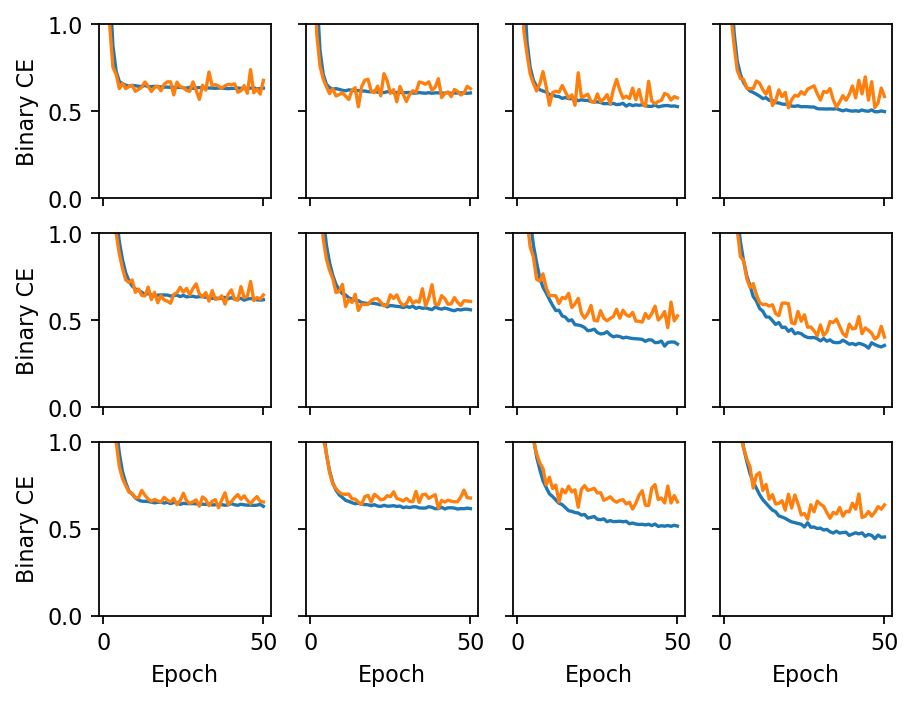

In [128]:
history_r = np.reshape(history, (models_I, models_J))

fig, ax = plt.subplots(len(features), len(targets[0]), sharex=True, sharey=True, dpi = 160)
for i in range(models_I) :
    for j in range(models_J) :
        ax[i, j].plot(np.arange(1, MAX_EPOCHS + 1), history_r[i, j].history['loss'], label = 'Loss')
        ax[i, j].plot(np.arange(1, MAX_EPOCHS + 1), history_r[i, j].history['val_loss'], label = 'Val Loss')
        ax[i, j].set(xlabel = ('Epoch' if i == 2 else ''), ylabel = ('Binary CE' if j == 0 else ''), ylim = [0., 1.])

ROC curves

In [129]:
y_pred = [dnn[0].predict(dnn[3], verbose=0) for dnn in models_dnn]
y_pred = np.reshape(y_pred, (models_I, models_J))

C:\Users\Ashtek\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [130]:
XY_test = [tuple(zip(*dnn[3])) for dnn in models_dnn]
y_true = [np.array(xy_test[1]) for xy_test in XY_test]
y_true = np.reshape(y_true, (models_I, models_J))

Model AUC score: 0.6896494188881732
Model AUC score: 0.7262565323123092
Model AUC score: 0.6574732814772656
Model AUC score: 0.5997747850368741
Model AUC score: 0.6668450282580717
Model AUC score: 0.708331812874033
Model AUC score: 0.5700522983759978
Model AUC score: 0.5880715470267709
Model AUC score: 0.678749918016659
Model AUC score: 0.677739942674612
Model AUC score: 0.6179947098694
Model AUC score: 0.5970689860598117


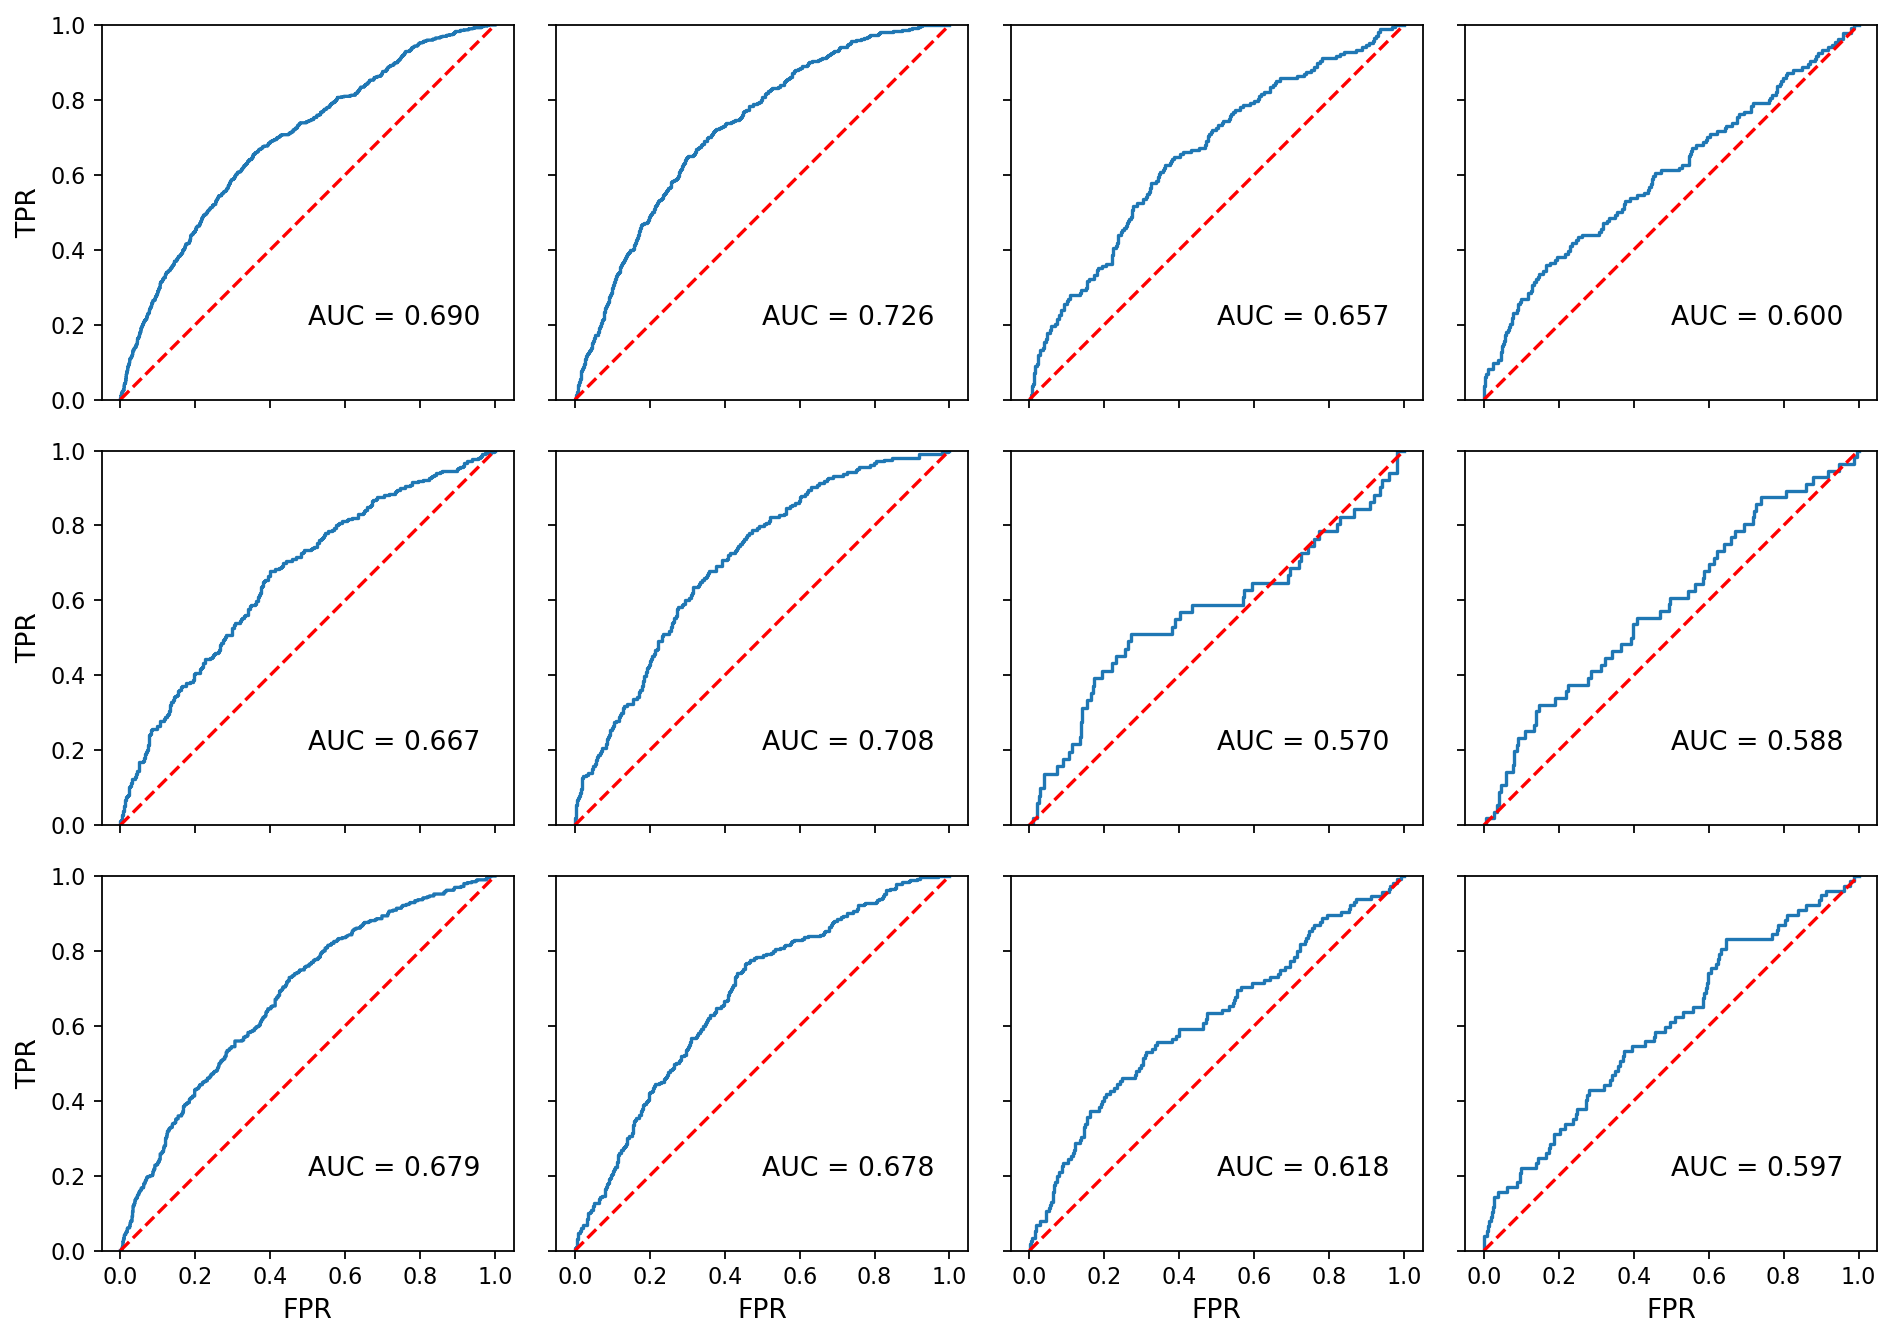

In [164]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))

for i in range(models_I) :
    for j in range(models_J) :
        fpr, tpr, thresholds = roc_curve(y_true[i, j], y_pred[i, j])  # test dataset
        ax[i, j].plot(fpr, tpr)
        ax[i, j].plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.5, 0.2, f'AUC = {roc_auc_score(y_true[i, j], y_pred[i, j]):.3f}', fontsize = 12)
        print(f'Model AUC score: {roc_auc_score(y_true[i, j], y_pred[i, j])}')

fig.tight_layout()

In [165]:
fig.savefig("ROC_MLP.png", dpi = 300) 

#### Evaluate XGBoost models (untuned)

C:\Users\Ashtek\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Model AUC score: 0.6798994431436635
Model AUC score: 0.6826201185332984
Model AUC score: 0.694246520130702
Model AUC score: 0.6255130054767273
Model AUC score: 0.6630633204755783
Model AUC score: 0.6859090624804552
Model AUC score: 0.6467119895925133
Model AUC score: 0.5755015114042319
Model AUC score: 0.6221984557770901
Model AUC score: 0.6671406118348565
Model AUC score: 0.6481676226896113
Model AUC score: 0.624452409398646


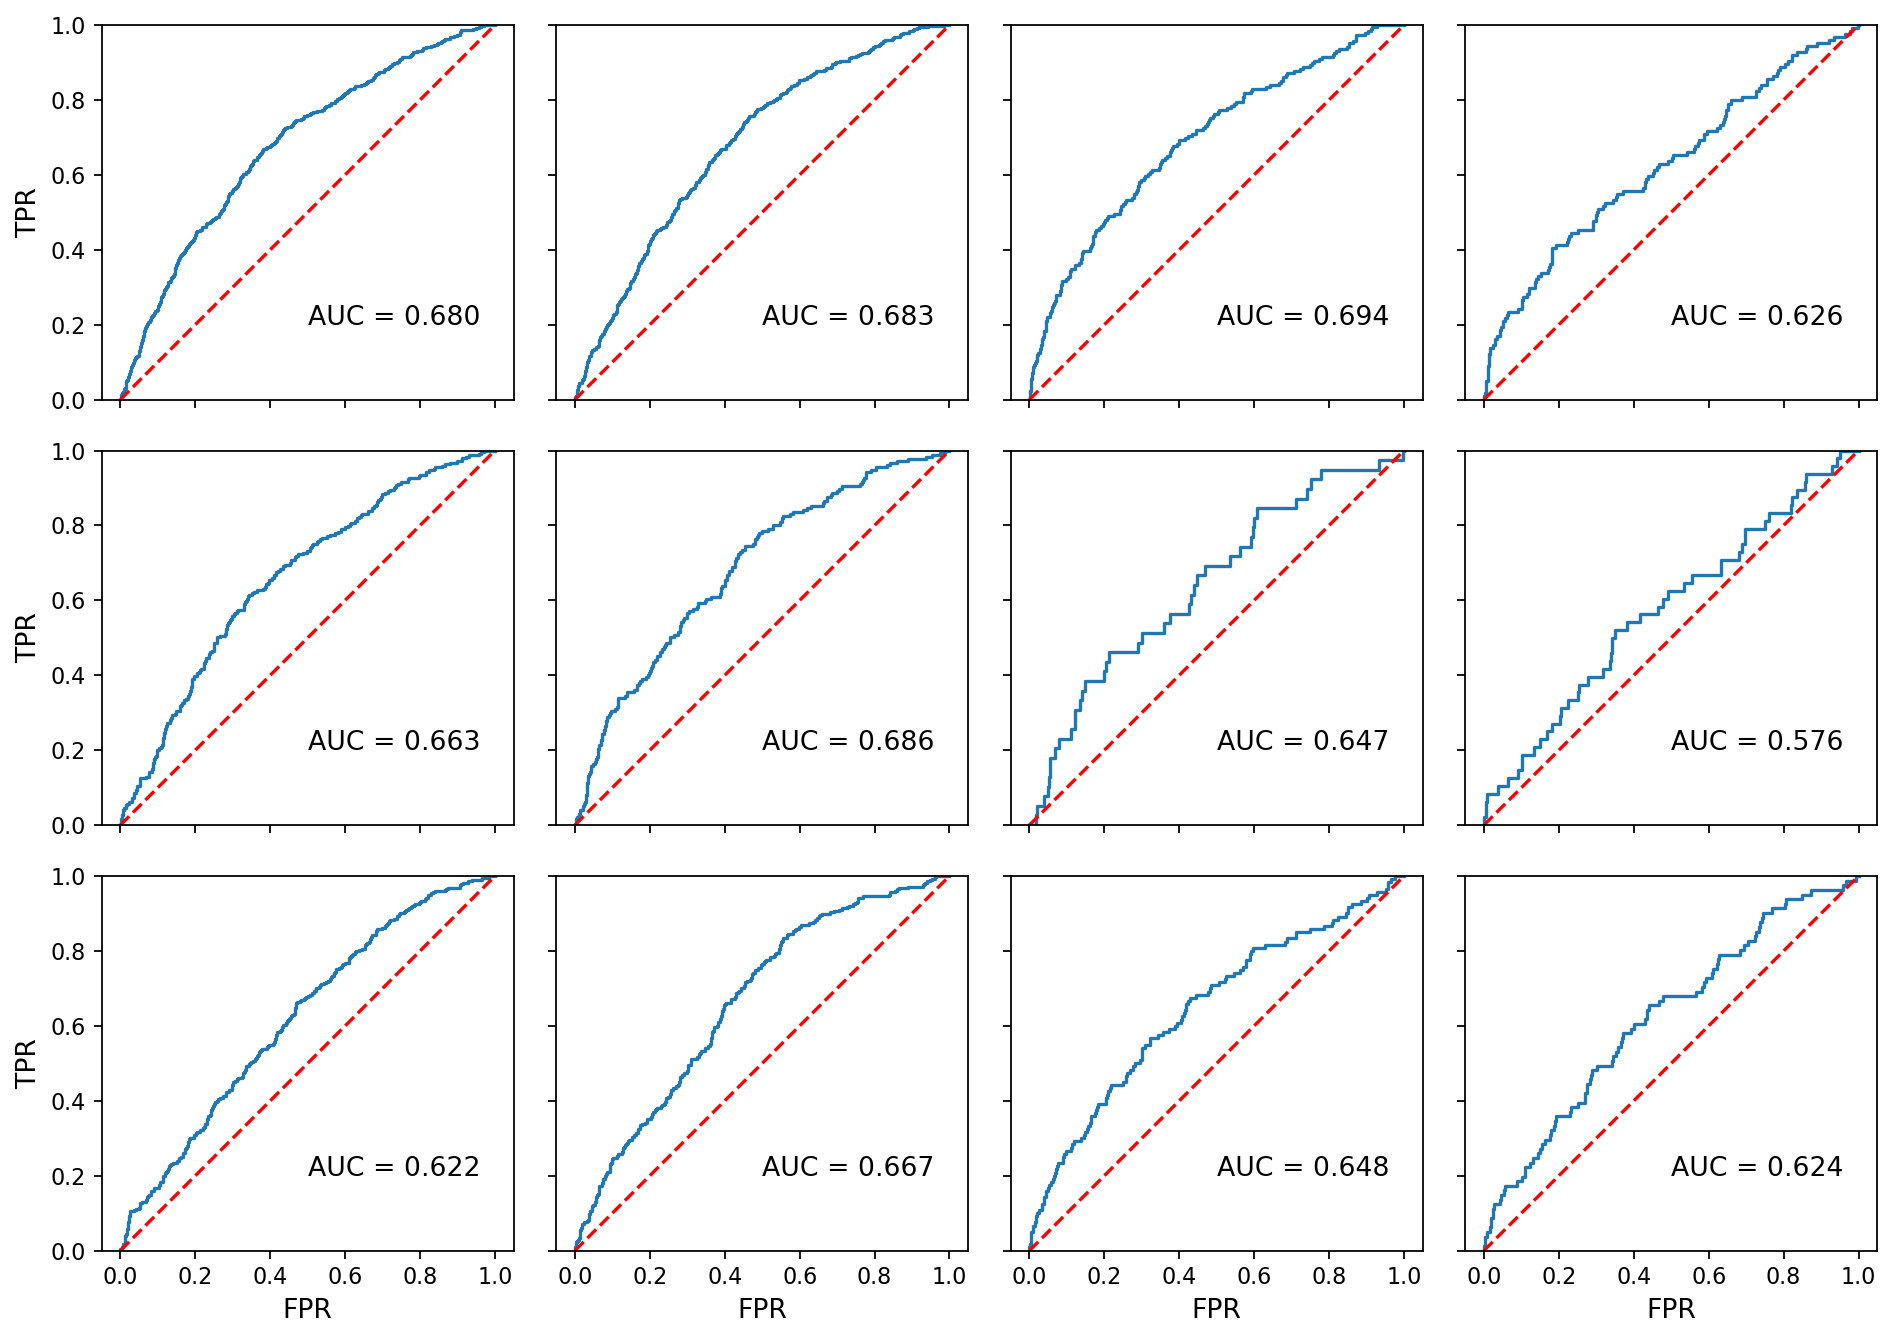

In [171]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))
XY_xgb_r = np.reshape(XY_xgb, (models_I, models_J, 4))
xgb_classifiers = np.reshape(xgb_classifiers, (models_I, models_J))
# xgb_classifiers_tuned = np.reshape(xgb_classifiers_tuned, (models_I, models_J))
for i in range(models_I) :
    for j in range(models_J) :
        xgb_cl = xgb_classifiers[i, j]
        x_test_xgb = XY_xgb_r[i, j][1]
        y_true_xgb = XY_xgb_r[i, j][3]
        y_pred_xgb = xgb_cl.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        # xgb_cl_tuned = xgb_classifiers_tuned[i, j]
        # y_pred_xgb_tuned = xgb_cl_tuned.predict_proba(x_test_xgb)
        # fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb_tuned[:,1])  # test dataset
        # ax[i, j].plot(fpr, tpr)
        ax[i, j].plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.5, 0.2, f'AUC = {roc_auc_score(y_true_xgb, y_pred_xgb[:,1]):.3f}', fontsize = 12)
        print(f'Model AUC score: {roc_auc_score(y_true_xgb, y_pred_xgb[:,1])}')
        
fig.tight_layout()

In [172]:
fig.savefig("ROC_XGB_Untuned.png", dpi = 300)

#### Evaluate XGBoost models (tuned)

C:\Users\Ashtek\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Model AUC score: 0.7129005623493707
Model AUC score: 0.7235160087589514
Model AUC score: 0.7381617269556122
Model AUC score: 0.7454372277394142
Model AUC score: 0.7022893947330826
Model AUC score: 0.7294389893051472
Model AUC score: 0.691006756473205
Model AUC score: 0.7177452596867272
Model AUC score: 0.6791965749497944
Model AUC score: 0.6865359064100072
Model AUC score: 0.6990519439133206
Model AUC score: 0.6786197872219377


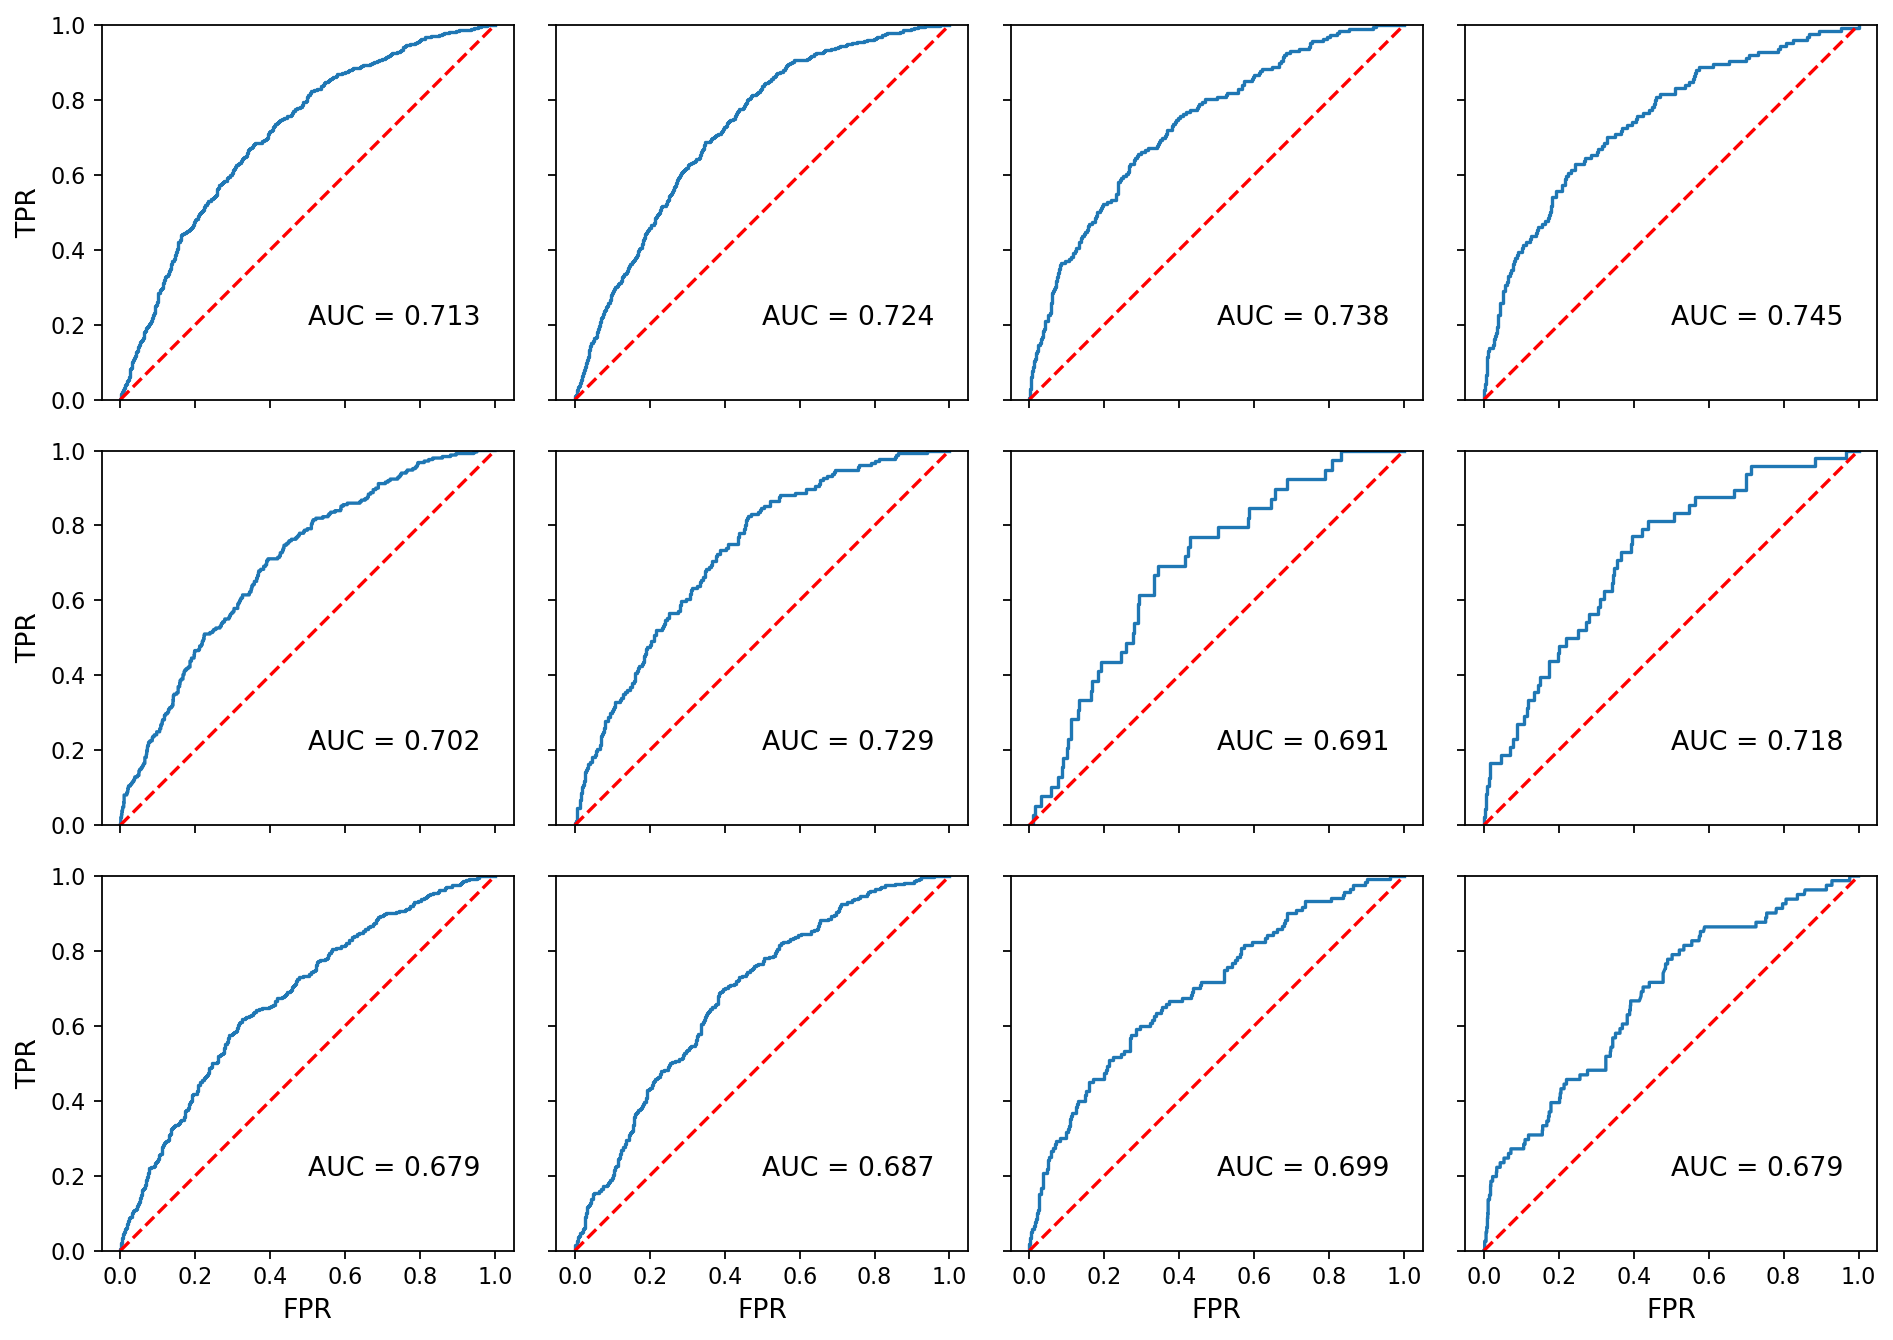

In [174]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))
XY_xgb_r = np.reshape(XY_xgb, (models_I, models_J, 4))
xgb_classifiers_tuned = np.reshape(xgb_classifiers_tuned, (models_I, models_J))
for i in range(models_I) :
    for j in range(models_J) :
        x_test_xgb = XY_xgb_r[i, j][1]
        y_true_xgb = XY_xgb_r[i, j][3]
        
        xgb_cl_tuned = xgb_classifiers_tuned[i, j]
        y_pred_xgb_tuned = xgb_cl_tuned.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb_tuned[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        ax[i, j].plot(np.linspace(0, 1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.5, 0.2, f'AUC = {roc_auc_score(y_true_xgb, y_pred_xgb_tuned[:,1]):.3f}', fontsize = 12)
        print(f'Model AUC score: {roc_auc_score(y_true_xgb, y_pred_xgb_tuned[:,1])}')
        
fig.tight_layout()

In [175]:
fig.savefig("ROC_XGB_Tuned.png", dpi = 300)

#### Compare DNN to XGBoost

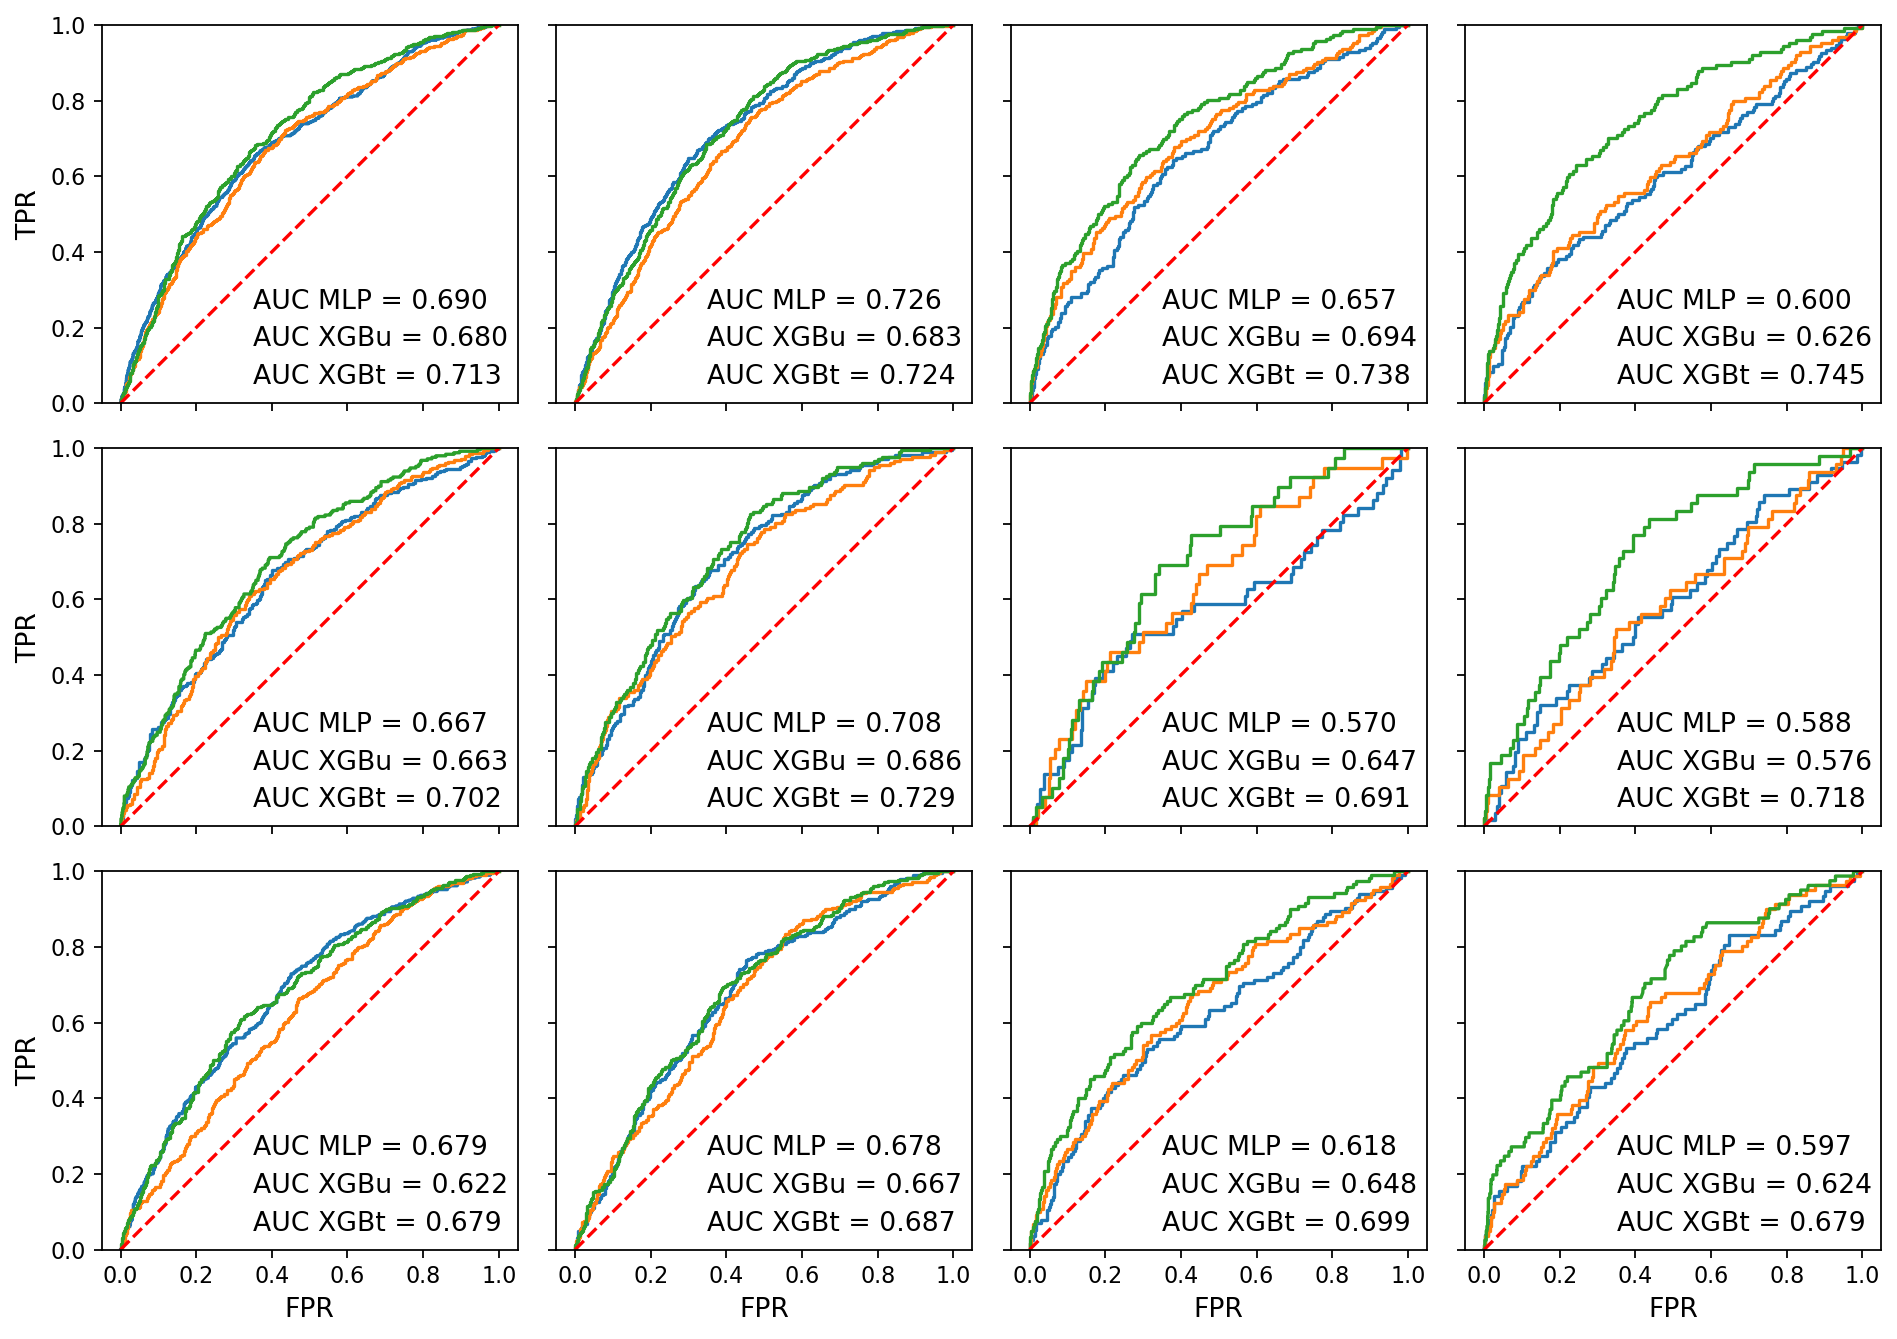

In [192]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))
fig.tight_layout()
for i in range(models_I) :
    for j in range(models_J) :
        # Baseline DNNs
        fpr, tpr, thresholds = roc_curve(y_true[i, j], y_pred[i, j])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        # XGBoost (Untuned)
        xgb_cl = xgb_classifiers[i, j]
        x_test_xgb = XY_xgb_r[i, j][1]
        y_true_xgb = XY_xgb_r[i, j][3]
        y_pred_xgb = xgb_cl.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        # XGBoost (Tuned)
        xgb_cl_tuned = xgb_classifiers_tuned[i, j]
        y_pred_xgb_tuned = xgb_cl_tuned.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb_tuned[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        ax[i, j].plot(np.linspace(0, 1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.35, 0.25, f'AUC MLP = {roc_auc_score(y_true[i, j], y_pred[i, j]):.3f}', fontsize = 12)
        ax[i, j].text(0.35, 0.15, f'AUC XGBu = {roc_auc_score(y_true_xgb, y_pred_xgb[:,1]):.3f}', fontsize = 12)
        ax[i, j].text(0.35, 0.05, f'AUC XGBt = {roc_auc_score(y_true_xgb, y_pred_xgb_tuned[:,1]):.3f}', fontsize = 12)
        ax[i, j].set(xlabel = ('FPR' if i == 2 else ''), ylabel = ('TPR' if j == 0 else ''), ylim = [0., 1.])

fig.tight_layout()

In [193]:
fig.savefig("ROC_Comparison.png", dpi = 300)

In [194]:
import dill
dill.dump_session('latest_notebook_session.db')

InvalidArgumentError: Cannot convert a Tensor of dtype variant to a NumPy array.

In [ ]:
dill.load_session('latest_notebook_session.db')

## Hyperparameter tuning

In [ ]:
class MyHyperModel(kt.HyperModel) :
    def __init__(self, normalizer):
        self.normalizer = normalizer
    
    def build(self, hp) : 
        model = tf.keras.Sequential()
        model.add(self.normalizer)
        # model.add(tf.keras.layers.Input(53))
        
        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 32-512
        hp_units = hp.Int('units', min_value=10, max_value=160, step=10)
        hp_layers = hp.Int('layers', min_value = 1, max_value = 6, step = 1)
        hp_l2reg = hp.Choice('lambda', values = [1e-4, 1e-3, 1e-2, 1e-1])
        for l in range(hp_layers):
            model.add(tf.keras.layers.Dense(units = hp_units, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(hp_l2reg)))
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

        return model
    
    
    def fit(self, hp, model, x, *args, **kwargs) :
        
        return model.fit(x, *args, **kwargs)

In [ ]:
tuner = kt.BayesianOptimization(hypermodel=MyHyperModel(normalizer),
                     objective = "val_accuracy", #optimize val acc
                     overwrite=True,  #overwrite previous results
                     directory='hyperband_search_dir', #Saving dir
                     project_name='CardiacClassifiers')

In [ ]:
tuner.search(x = train_ds, steps_per_epoch = STEPS_PER_EPOCH, epochs=50, validation_data = validate_ds)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)
h_model = MyHyperModel(normalizer)
model = h_model.build(best_hps[0])

In [ ]:
MAX_EPOCHS = 200
history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = MAX_EPOCHS,
    validation_data = validate_ds,
    verbose = 1)

In [ ]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();